In [43]:
from tqdm import tqdm
import requests
import pandas as pd
import os
from bs4 import BeautifulSoup
import time
from io import StringIO
import re

In [2]:
newest_gw = 3

In [292]:
fpl_players_path = f"C:/Users/erknud3/fpl-optimization/model/data/New_Season_Data/fpl_players_new_season_gw{newest_gw}.csv"

# Check if files exist
if not (
    os.path.exists(fpl_players_path)
):
    raise FileNotFoundError(
        f"One or more necessary files do not exist for gameweek {newest_gw}."
    )

fpl_players = pd.read_csv(fpl_players_path)

fpl_players = fpl_players[["fbref", "fpl_id", "Player", "weighted_npxG", "weighted_xAG"]]

fpl_players["weighted_npxGI"] = fpl_players["weighted_npxG"] + fpl_players["weighted_xAG"]

fpl_players.dropna(subset=["weighted_npxGI"], inplace=True)

In [293]:
fpl_players = fpl_players.sort_values(by="weighted_npxGI", ascending=False)

In [145]:
# Initialize an empty list to store the URLs
player_urls = []

# Loop through each row in the DataFrame
for index, row in fpl_players.iterrows():
    fbref_id = row['fbref']
    player_name = row['Player']
    player_name_url = player_name.replace(' ', '-')
    url = f"https://fbref.com/en/players/{fbref_id}/{player_name_url}"
    player_urls.append(url)

# Output the list of URLs
print(player_urls)

['https://fbref.com/en/players/1f44ac21/Erling-Haaland', 'https://fbref.com/en/players/4d77b365/Darwin-Núñez', 'https://fbref.com/en/players/e342ad68/Mohamed-Salah', 'https://fbref.com/en/players/e46012d4/Kevin-De-Bruyne', 'https://fbref.com/en/players/dc7f8a28/Cole-Palmer', 'https://fbref.com/en/players/178ae8f8/Diogo-Jota', 'https://fbref.com/en/players/8450467d/Ali-Al-Hamadi', 'https://fbref.com/en/players/9c36ed83/Nicolas-Jackson', 'https://fbref.com/en/players/b66315ae/Gabriel-Jesus', 'https://fbref.com/en/players/d3d774cc/Marc-Guiu', 'https://fbref.com/en/players/4a1a9578/Luis-Díaz', 'https://fbref.com/en/players/9cfbad36/Julio-Enciso', 'https://fbref.com/en/players/8e92be30/Alexander-Isak', 'https://fbref.com/en/players/92e7e919/Son-Heung-min', 'https://fbref.com/en/players/aed3a70f/Ollie-Watkins', 'https://fbref.com/en/players/bc7dc64d/Bukayo-Saka', 'https://fbref.com/en/players/ed1e53f3/Phil-Foden', 'https://fbref.com/en/players/507c7bdf/Bruno-Fernandes', 'https://fbref.com/en

In [148]:
seasons = ['2023-2024', '2024-2025']

# Function to construct season links from player URL
def construct_season_links(player_url, seasons):
    # Extract the base part of the URL, player ID, and player name
    base_url = player_url.split('/players/')[0]
    fbref_id = player_url.split('/players/')[1].split('/')[0]
    player_name = player_url.split('/')[-1]
    
    # Construct the season URLs and return them as a single list
    return [
        f"{base_url}/players/{fbref_id}/matchlogs/{season}/summary/{player_name}-Match-Logs"
        for season in seasons
    ]

# Loop through each player URL and construct the season URLs, flattening the results directly
all_season_links = []
for url in player_urls:
    season_links = construct_season_links(url, seasons)
    all_season_links.extend(season_links)  # extend the list instead of appending
    #print(f'URL: {url}')
    #print('Constructed Season Links:', season_links)
    #print('---')
    

In [243]:
all_dfs = []

# Initialize the progress bar
with tqdm(total=len(all_season_links), desc="Processing URLs") as pbar:
    for url in all_season_links:
        try:
            data = requests.get(url)
            soup = BeautifulSoup(data.text, 'html.parser')
            ids = re.search(r'/players/([a-zA-Z0-9]{8})/', url)
            season = re.search(r'/(\d{4}-\d{4})/', url)

            table = soup.find("table", {"id": "matchlogs_all"})

            df = pd.read_html(StringIO(str(table)))[0]
            df.columns = [f"{i} {j}" if "Unnamed" not in i else j for i, j in df.columns]
            df = df[["Date", "Day", "Comp", "Round", "Venue", "Result", "Squad", "Opponent", "Start", "Pos", "Min"]]

            # Add fbref ID and season columns
            df["fbref"] = ids.group(1)
            df['Season'] = season.group(1)
            cols_to_move = ["fbref", "Season"]
            remaining_cols = [col for col in df.columns if col not in cols_to_move]
            new_order = remaining_cols[:1] + cols_to_move + remaining_cols[1:]
            
            df = df[new_order]
            df.dropna(inplace=True)
            #df = df[df['Comp'] == "Premier League"]

            # Append the DataFrame to the list
            all_dfs.append(df)

            # Sleep to avoid overloading the server
            time.sleep(12)

        except Exception as e:
            print(f"An error occurred for URL: {url}: {e}")

        # Update the progress bar
        pbar.update(1)

Processing URLs:   0%|          | 0/704 [00:00<?, ?it/s]

Processing URLs:  81%|████████  | 571/704 [2:03:27<20:37,  9.31s/it]  

An error occurred for URL: https://fbref.com/en/players/132a82f1/matchlogs/2023-2024/summary/Wesley-Fofana-Match-Logs: No tables found


Processing URLs: 100%|██████████| 704/704 [2:32:18<00:00, 12.98s/it]


In [307]:
fpl_players_match_logs = pd.concat(all_dfs)

In [308]:
fpl_players_match_logs = fpl_players_match_logs.merge(fpl_players[['fbref', "fpl_id", 'Player', 'weighted_npxGI']], on='fbref', how='inner')

In [309]:
fpl_players_match_logs['Min'] = fpl_players_match_logs['Min'].apply(lambda x: 0 if x == 'On matchday squad, but did not play' else x)
fpl_players_match_logs['Pos'] = fpl_players_match_logs['Pos'].apply(lambda x: 'Benched' if x == 'On matchday squad, but did not play' else x)
fpl_players_match_logs['Min'] = fpl_players_match_logs['Min'].astype(int)

In [310]:
fpl_players_match_logs = fpl_players_match_logs[fpl_players_match_logs['Comp'].isin(['Premier League', 'Bundesliga', 'La Liga', 'Serie A', 'Ligue 1', 'Primeira Liga', 'Championship', 'Eredivisie'])]

In [312]:
fpl_players_match_logs.to_csv("C:/Users/erknud3/fpl-optimization/model/data/Historic_Data/match_logs_prev_seasons.csv", index=False)

In [298]:
# Convert 'Date' to datetime and sort the data
fpl_players_match_logs['Date'] = pd.to_datetime(fpl_players_match_logs['Date'])
fpl_players_match_logs.sort_values(by=['fbref', 'Date'], inplace=True)

# Feature Engineering
fpl_players_match_logs['Start_Flag'] = fpl_players_match_logs['Start'].apply(lambda x: 1 if x in ['Y', 'Y*'] else 0)
fpl_players_match_logs['Play_1_Min'] = fpl_players_match_logs['Min'].apply(lambda x: 1 if x > 0 else 0)
fpl_players_match_logs['Play_60_Min'] = fpl_players_match_logs['Min'].apply(lambda x: 1 if x >= 60 else 0)

# Assume fpl_players_match_logs is already sorted and contains the data
# Create a flag for squad changes
fpl_players_match_logs['Squad_Change'] = fpl_players_match_logs.groupby('fbref')['Squad'].transform(lambda x: x != x.shift())

# Calculate long-term trend based on the previous season
fpl_players_match_logs['Previous_Season_Minutes'] = fpl_players_match_logs.groupby(['fbref', 'Season'])['Min'].transform(lambda x: x.shift(1).expanding().mean()).round(2)
fpl_players_match_logs['Previous_Season_Minutes'] = fpl_players_match_logs['Previous_Season_Minutes'].ffill()

# Weight the long-term trend less if there's a squad change
fpl_players_match_logs['Baseline_Minutes'] = fpl_players_match_logs['Previous_Season_Minutes']
fpl_players_match_logs.loc[fpl_players_match_logs['Squad_Change'], 'Baseline_Minutes'] *= 0.5

# Calculate EMA for the current season
fpl_players_match_logs['Current_Season_Minutes_EMA'] = fpl_players_match_logs.groupby(['fbref', 'Season'])['Min'].transform(lambda x: x.ewm(span=6).mean()).round(2)

# Combine the baseline and current season EMA to get the expected minutes
fpl_players_match_logs['Expected_Minutes'] = (fpl_players_match_logs['Baseline_Minutes'] * 0.3 + fpl_players_match_logs['Current_Season_Minutes_EMA'] * 0.7).round(2)

# Optional: Clip values to avoid extreme outliers
fpl_players_match_logs['Expected_Minutes'] = fpl_players_match_logs['Expected_Minutes'].clip(lower=0, upper=90)


In [299]:
# Calculate long-term trends for start, play at least 1 minute, and play at least 60 minutes

# P(start) - Long-term trend based on the previous season
fpl_players_match_logs['Previous_Season_P(start)'] = fpl_players_match_logs.groupby(['fbref', 'Season'])['Start_Flag'].transform(lambda x: x.shift(1).expanding().mean()).round(2)
fpl_players_match_logs['Previous_Season_P(start)'] = fpl_players_match_logs['Previous_Season_P(start)'].ffill()

# P(play_1_min) - Long-term trend based on the previous season
fpl_players_match_logs['Previous_Season_P(play_1_min)'] = fpl_players_match_logs.groupby(['fbref', 'Season'])['Play_1_Min'].transform(lambda x: x.shift(1).expanding().mean()).round(2)
fpl_players_match_logs['Previous_Season_P(play_1_min)'] = fpl_players_match_logs['Previous_Season_P(play_1_min)'].ffill()

# P(play_60_min) - Long-term trend based on the previous season
fpl_players_match_logs['Previous_Season_P(play_60_min)'] = fpl_players_match_logs.groupby(['fbref', 'Season'])['Play_60_Min'].transform(lambda x: x.shift(1).expanding().mean()).round(2)
fpl_players_match_logs['Previous_Season_P(play_60_min)'] = fpl_players_match_logs['Previous_Season_P(play_60_min)'].ffill()

# Weight the long-term trends less if there's a squad change
fpl_players_match_logs['Baseline_P(start)'] = fpl_players_match_logs['Previous_Season_P(start)']
fpl_players_match_logs['Baseline_P(play_1_min)'] = fpl_players_match_logs['Previous_Season_P(play_1_min)']
fpl_players_match_logs['Baseline_P(play_60_min)'] = fpl_players_match_logs['Previous_Season_P(play_60_min)']

fpl_players_match_logs.loc[fpl_players_match_logs['Squad_Change'], 'Baseline_P(start)'] *= 0.5
fpl_players_match_logs.loc[fpl_players_match_logs['Squad_Change'], 'Baseline_P(play_1_min)'] *= 0.5
fpl_players_match_logs.loc[fpl_players_match_logs['Squad_Change'], 'Baseline_P(play_60_min)'] *= 0.5

# Calculate EMA for the current season for each probability
fpl_players_match_logs['Current_Season_P(start)_EMA'] = fpl_players_match_logs.groupby(['fbref', 'Season'])['Start_Flag'].transform(lambda x: x.ewm(span=6).mean()).round(2)
fpl_players_match_logs['Current_Season_P(play_1_min)_EMA'] = fpl_players_match_logs.groupby(['fbref', 'Season'])['Play_1_Min'].transform(lambda x: x.ewm(span=6).mean()).round(2)
fpl_players_match_logs['Current_Season_P(play_60_min)_EMA'] = fpl_players_match_logs.groupby(['fbref', 'Season'])['Play_60_Min'].transform(lambda x: x.ewm(span=6).mean()).round(2)

# Combine the baseline and current season EMA to get the final probabilities
fpl_players_match_logs['P(start)'] = (fpl_players_match_logs['Baseline_P(start)'] * 0.3 + fpl_players_match_logs['Current_Season_P(start)_EMA'] * 0.7).round(2)
fpl_players_match_logs['P(play_1_min)'] = (fpl_players_match_logs['Baseline_P(play_1_min)'] * 0.3 + fpl_players_match_logs['Current_Season_P(play_1_min)_EMA'] * 0.7).round(2)
fpl_players_match_logs['P(play_60_min)'] = (fpl_players_match_logs['Baseline_P(play_60_min)'] * 0.3 + fpl_players_match_logs['Current_Season_P(play_60_min)_EMA'] * 0.7).round(2)


In [300]:
fpl_players_match_logs = fpl_players_match_logs[['Date', 'fbref', "fpl_id", 'Player', 'weighted_npxGI', 'Season', 'Comp', 'Round', 'Squad', 'Opponent','Min', 'Start_Flag', 'Expected_Minutes', 'P(start)', 'P(play_1_min)', 'P(play_60_min)']]

In [301]:
test = fpl_players_match_logs[fpl_players_match_logs['fbref'] == '8e92be30']

In [302]:
test.sort_values(by='Date', ascending=False).head(20)

,Date,fbref,fpl_id,Player,weighted_npxGI,Season,Comp,Round,Squad,Opponent,Min,Start_Flag,Expected_Minutes,P(start),P(play_1_min),P(play_60_min)
644,2024-09-01,8e92be30,401,Alexander Isak,0.63,2024-2025,Premier League,Matchweek 3,Newcastle Utd,Tottenham,90,1,90.00,1.00,1.00,1.00
642,2024-08-25,8e92be30,401,Alexander Isak,0.63,2024-2025,Premier League,Matchweek 2,Newcastle Utd,Bournemouth,90,1,90.00,1.00,1.00,1.00
641,2024-08-17,8e92be30,401,Alexander Isak,0.63,2024-2025,Premier League,Matchweek 1,Newcastle Utd,Southampton,90,1,84.75,0.96,0.99,0.95
639,2024-05-19,8e92be30,401,Alexander Isak,0.63,2023-2024,Premier League,Matchweek 38,Newcastle Utd,Brentford,80,1,79.01,0.96,0.99,0.95
638,2024-05-15,8e92be30,401,Alexander Isak,0.63,2023-2024,Premier League,Matchweek 34,Newcastle Utd,Manchester Utd,90,1,79.33,0.96,0.99,0.94
637,2024-05-11,8e92be30,401,Alexander Isak,0.63,2023-2024,Premier League,Matchweek 37,Newcastle Utd,Brighton,67,1,77.28,0.96,0.99,0.94
636,2024-05-04,8e92be30,401,Alexander Isak,0.63,2023-2024,Premier League,Matchweek 36,Newcastle Utd,Burnley,76,1,80.75,0.96,0.99,0.94
635,2024-04-27,8e92be30,401,Alexander Isak,0.63,2023-2024,Premier League,Matchweek 35,Newcastle Utd,Sheffield Utd,90,1,82.93,0.96,0.99,0.93
634,2024-04-24,8e92be30,401,Alexander Isak,0.63,2023-2024,Premier League,Matchweek 29,Newcastle Utd,Crystal Palace,90,1,82.13,0.94,0.99,0.92
633,2024-04-13,8e92be30,401,Alexander Isak,0.63,2023-2024,Premier League,Matchweek 33,Newcastle Utd,Tottenham,90,1,81.08,0.94,0.99,0.91


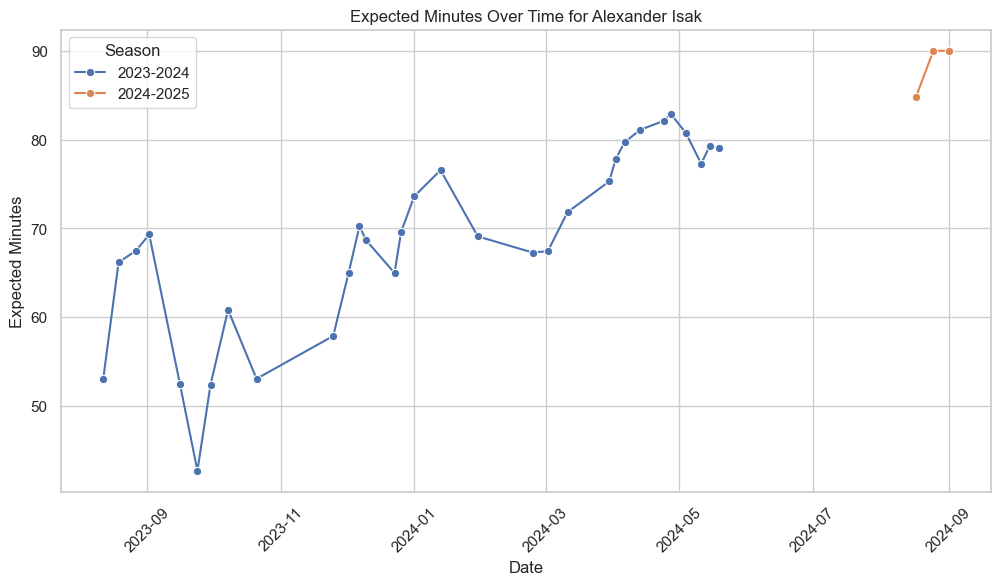

In [274]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for the plots
sns.set(style="whitegrid")

# Select a player by their Fbref ID
player_name = test['Player'].max()
player_data = test

# Plot Expected Minutes Over Time, grouped by Squad
plt.figure(figsize=(12, 6))
sns.lineplot(data=player_data, x='Date', y='Expected_Minutes', hue='Season', marker='o')
plt.title(f"Expected Minutes Over Time for {player_name}")
plt.xlabel("Date")
plt.ylabel("Expected Minutes")
plt.xticks(rotation=45)
plt.legend(title='Season')
plt.show()


In [303]:
fpl_players_match_logs.to_csv("C:\\Users\\erknud3\\fpl-optimization\\model\\data\\Historic_Data\\fpl_players_match_logs.csv", index=False)

In [304]:
# Ensure the data is sorted by 'fbref' and 'Date' so the most recent rows are at the end
fpl_players_match_logs.sort_values(by=['fbref', 'Date'], inplace=True)

# Drop duplicates, keeping only the last entry (which is the most recent) for each player ('fbref')
fpl_players_xmins = fpl_players_match_logs.drop_duplicates(subset=['fbref'], keep='last')

# Reset the index for the new dataframe (optional, for cleaner presentation)
fpl_players_xmins.reset_index(drop=True, inplace=True)

fpl_players_xmins = fpl_players_xmins[['Date', 'fbref', 'fpl_id', 'Player', 'Season', 'Comp', 'Round', 'Squad', 'Min', 'Start_Flag', 'Expected_Minutes', 'P(start)', 'P(play_1_min)', 'P(play_60_min)', 'weighted_npxGI']]

fpl_players_xmins = fpl_players_xmins.rename(
    {
        'Min': 'Mins',
        'Start_Flag': 'Start',
        'Expected_Minutes': 'xMins',
        'P(play_1_min)': 'P(1_min)',
        'P(play_60_min)': 'P(60_min)'
    },
    axis=1
)

fpl_players_xmins = fpl_players_xmins.sort_values(by='weighted_npxGI', ascending=False)

In [305]:
fpl_players_xmins.to_csv("C:\\Users\\erknud3\\fpl-optimization\\model\\data\\New_Season_Data\\fpl_players_xmins.csv", index=False)